Cepstrum Pitch Detection
=

# Technical Overview

The core of cepstrum pitch detection is the idea of leveraging the cepstrum, which is a manipulation of the original signal. The goal of the cepstrum is to extract a more useful signal; in particular, it is useful for identifying the fundamental frequency in the sample.

The cepstrum is defined as the Fourier transform of the log of the Fourier transform of the original signal. That is, `FFT(log(FFT(signal)))`.

The first Fourier transform brings us from the time domain to the frequency domain. This gives us the magnitude of each frequency present in the signal.

The next key observation is that in this data, we expect some kind of periodic pattern related to the pitch we're trying to detect. In particular, we expect a higher presence of the fundamental frequency and its multiples (the overtones), and in the frequency domain, these would look like peaks in regular intervals. Thus, we can try to take another Fourier transform to identify this pattern - in the resulting data, we expect a single peak at the fundamental frequency of the original signal.

In cepstrum analysis, there is often an extra step between the two transforms that takes the log. The theory behind it ties back to speech analysis, wherein we expect the signal to be of the form $Y(t) = X(t) * H(t)$, where $X(t)$ are the locations of the harmonics (excitation), and $H(t)$ are the filters (vocal tract) applied through convolution. Taking the log gives $\log Y(t) = \log X(t) + \log H(t)$, allowing these aspects to be separated.

# Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.io.wavfile as wav

In [2]:
class CepstrumStepper:
    def __init__(self, signal, fmin=50, fmax=4000, fs=44100):
        self.signal = signal
        self.fmin = fmin
        self.fmax = fmax
        self.fs = fs
        self.time_vector = np.arange(len(signal))/fs
    
    def run_all(self, signal_plot_to=0.01, use_log=True, threshold=None, show_plots=False):
        if show_plots:
            self.plot_signal(plot_to=signal_plot_to)
        
        self.plot_spectrum(use_log, threshold, show_plots=show_plots)
        self.plot_cepstrum(show_plots=show_plots)
        f0 = self.pick_fundamental()

        if show_plots:
            print('Estimated fundamental frequency: {:.2f} Hz'.format(f0))

        return f0
    
    def plot_signal(self, plot_to=0.01):
        fig, ax = plt.subplots()
        ax.plot(self.time_vector, self.signal)
        ax.set_xlim(0, plot_to)
        ax.set_xlabel('time (s)')
        ax.set_title('time signal')
    
    def plot_spectrum(self, use_log=True, threshold=None, show_plots=True):
        plot_title = 'Fourier spectrum'
        
        dt = 1 / self.fs
        self.freq_vector = np.fft.rfftfreq(len(self.signal), dt)
        X = np.fft.rfft(self.signal)
        if use_log:
            X = np.abs(np.log(np.abs(X)))
            plot_title = 'Logarithmic ' + plot_title
        else:
            X = np.abs(X)

        # thresholding
        if threshold is not None:
            X -= threshold
            X[X < 0] = 0
            plot_title += ' (thresholded)'
        
        self.spectrum = X

        if show_plots:
            fig, ax = plt.subplots()
            ax.plot(self.freq_vector, X)
            ax.title.set_text(plot_title)
            ax.set_xlabel('frequency (Hz)')
    
    def plot_cepstrum(self, show_plots=True):
        self.cepstrum = np.fft.rfft(self.spectrum)
        df = self.freq_vector[1] - self.freq_vector[0]
        self.quefrency_vector = np.fft.rfftfreq(self.spectrum.size, df)

        plot_to = int(len(self.quefrency_vector) * 0.1)

        if show_plots:
            fig, ax = plt.subplots()
            ax.plot(self.quefrency_vector[10:plot_to], np.abs(self.cepstrum)[10:plot_to])
            ax.set_xlabel('quefrency (s)')
            ax.set_title('cepstrum')
            
            fig, ax = plt.subplots()
            ax.plot(1/self.quefrency_vector[10:plot_to], np.abs(self.cepstrum)[10:plot_to])
            ax.set_xlabel('frequency (Hz)')
            ax.set_title('cepstrum')
    
    def pick_fundamental(self):
        valid = (self.quefrency_vector > 1/self.fmax) & (self.quefrency_vector <= 1/self.fmin)
        max_quefrency_index = np.argmax(np.abs(self.cepstrum)[valid])
        f0 = 1/self.quefrency_vector[valid][max_quefrency_index]
        return f0

    def top_n_fundamentals(self, n=5):
        valid = (self.quefrency_vector > 1/self.fmax) & (self.quefrency_vector <= 1/self.fmin)
        max_quefrency_indices = np.argsort(np.abs(self.cepstrum)[valid])[-n:]
        f0s = 1/self.quefrency_vector[valid][max_quefrency_indices]
        print('Top {} estimated fundamental frequencies:'.format(n))
        for i, f0 in enumerate(f0s)[::-1]:
            print('{}. {:.2f} Hz'.format(i+1, f0))
        return f0s

## Synthetic Signal

This example uses a synthetically generated signal as a simple case. For this first run, we have a tone with decaying magnitudes for the harmonic, with no noise.

In [3]:
def generate_signal(f0, shape="exponential", noise_level=0, duration=0.5, fs=44100, n=7, sigma=1, bump_max=1, verbose=False):
    """
    Generate a signal with multiple harmonics.
    
    :param f0: fundamental frequency
    :param shape: shape of the magnitudes of the harmonics (spectral envelope)
    :param noise_level: standard deviation of the noise
    :param duration: duration of the signal in seconds
    :param fs: sampling frequency
    :param n: number of harmonics
    :param sigma: standard deviation of the Gaussian bump (only used if shape is "bump")
    :param bump_max: maximum value of the Gaussian bump (only used if shape is "bump" or "uniform")
    :return: the generated signal
    """
    magnitudes = None
    if shape == "exponential":
        magnitudes = np.exp(-np.linspace(0, 1, n))
    elif shape == "linear":
        magnitudes = np.linspace(1, 0, n)
    elif shape == "bump":
        x = np.linspace(-1, 1, n)
        bump = np.exp(- (x / sigma) ** 2)
        bump = bump / np.max(bump)
        magnitudes = bump_max * bump
    elif shape == "random":
        magnitudes = np.random.rand(n)
    elif shape == "uniform":
        magnitudes = np.ones(n) * bump_max
    else:
        raise ValueError(f"Invalid shape: {shape}")

    if verbose:
        print("Magnitudes:", magnitudes)

    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    signal = sum([m * np.sin(2 * np.pi * f0 * t * (i+1)) for i, m in enumerate(magnitudes)])

    if noise_level > 0:
        noise = np.random.normal(0, noise_level, len(signal))
        signal += noise

    return signal

In [4]:
simple_synthetic = CepstrumStepper(
    generate_signal(339, "exponential", verbose=True)
)

Magnitudes: [1.         0.84648172 0.71653131 0.60653066 0.51341712 0.43459821
 0.36787944]


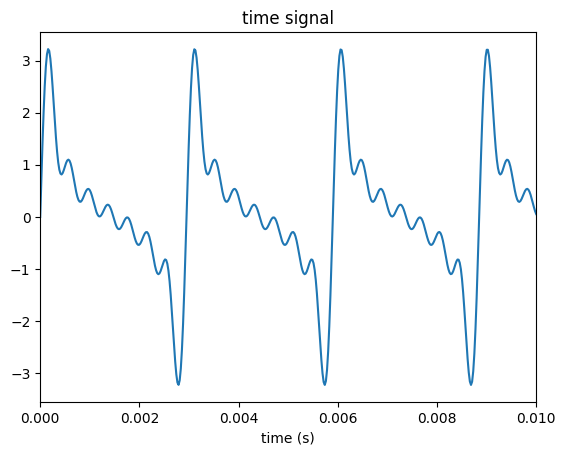

In [5]:
simple_synthetic.plot_signal()

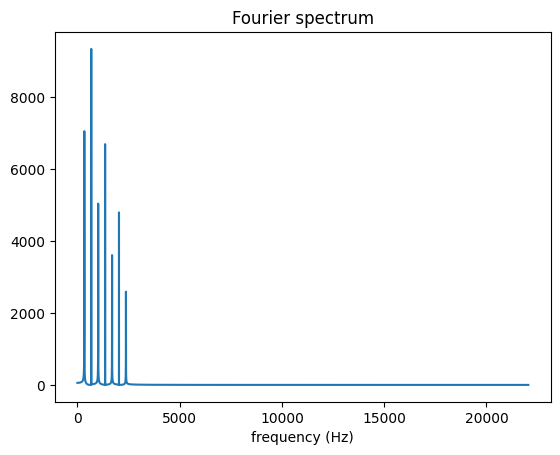

In [6]:
simple_synthetic.plot_spectrum(use_log=False)

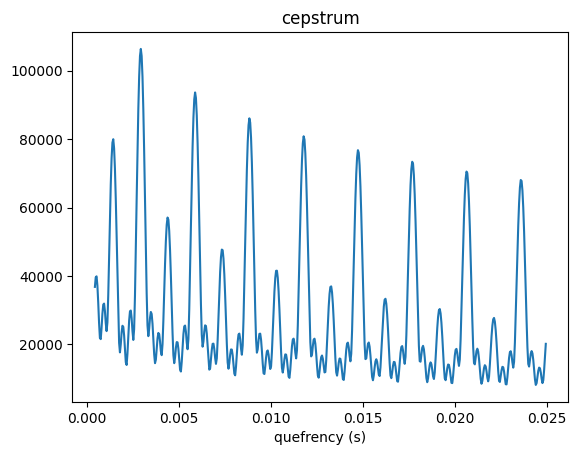

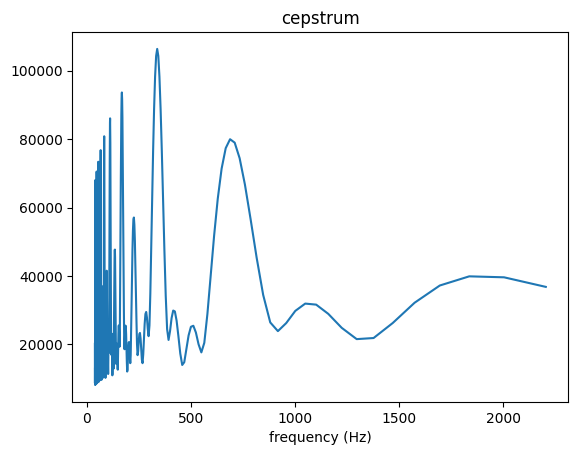

In [7]:
simple_synthetic.plot_cepstrum()

In [8]:
simple_synthetic.pick_fundamental()

339.26153846153846

Let's try another quick example with something less obvious: a spectral envelope more like a bump, with small values on the ends and larger values towards the middle. This shape is generated according to a normal distribution. Let's also add some noise.

Magnitudes: [0.36787944 0.64118039 0.89483932 1.         0.89483932 0.64118039
 0.36787944]
Estimated fundamental frequency: 441.04 Hz


441.04

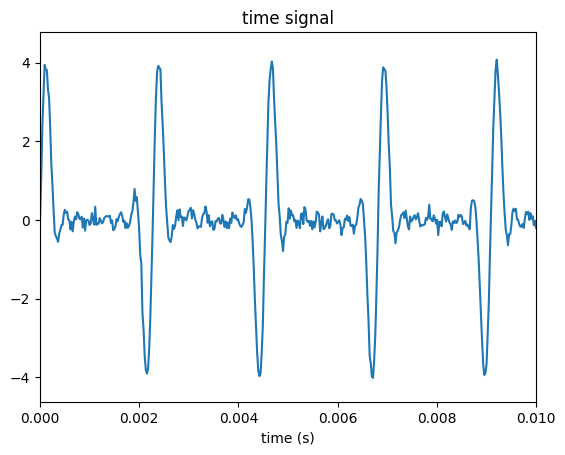

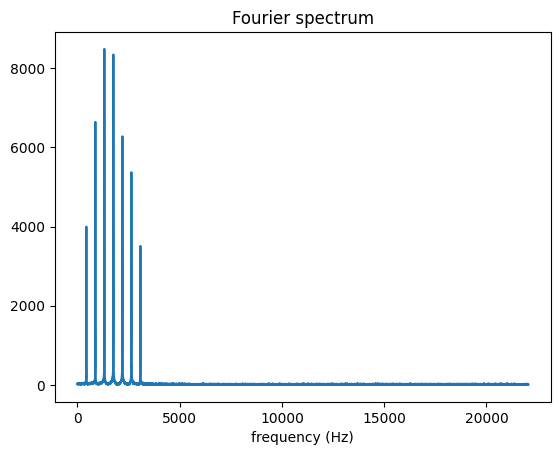

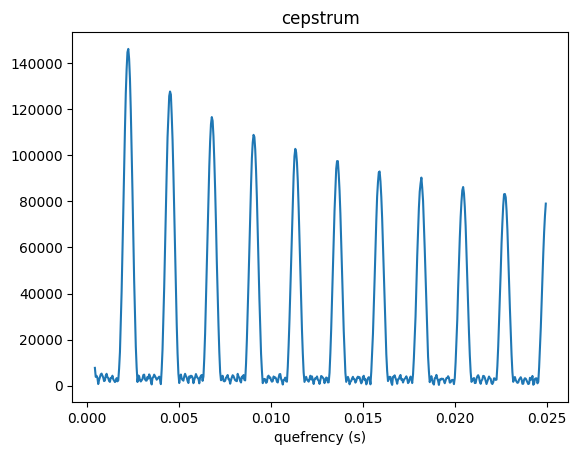

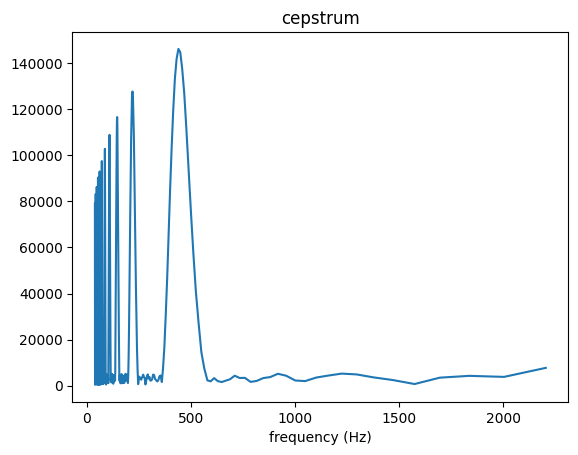

In [9]:
bump_synthetic = CepstrumStepper(
    generate_signal(440.2, "bump", noise_level=0.1, bump_max=1, sigma=1, verbose=True)
)
bump_synthetic.run_all(use_log=False, show_plots=True)

Let's try some more examples. The following code steps through varying noise levels to see how robust the algorithm is. For each noise level, we'll sample 100 random frequencies between 100Hz and 1000Hz and take the mean squared error. A prediction will be counted as "correct" if it's within 2% of the target frequency.

In [10]:
noise_levels = [0, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
mse_nolog = []
mse_log = []
correct_nolog = []
correct_log = []
num_samples = 100

for noise_level in noise_levels:
    err_nolog = 0
    err_log = 0
    c_nolog = 0
    c_log = 0
    for _ in range(num_samples):
        ground_truth = random.randint(100, 1000)
        signal = generate_signal(ground_truth, "exponential", noise_level=noise_level)
        stepper = CepstrumStepper(signal)

        pred_nolog = stepper.run_all(use_log=False)
        err_nolog += (pred_nolog - ground_truth) ** 2 / num_samples
        if np.abs(pred_nolog - ground_truth) / ground_truth < 0.02:
            c_nolog += 1

        pred_log = stepper.run_all(use_log=True)
        err_log += (pred_log - ground_truth) ** 2 / num_samples
        if np.abs(pred_log - ground_truth) / ground_truth < 0.02:
            c_log += 1

    mse_nolog.append(err_nolog)
    mse_log.append(err_log)
    correct_nolog.append(c_nolog / num_samples)
    correct_log.append(c_log / num_samples)

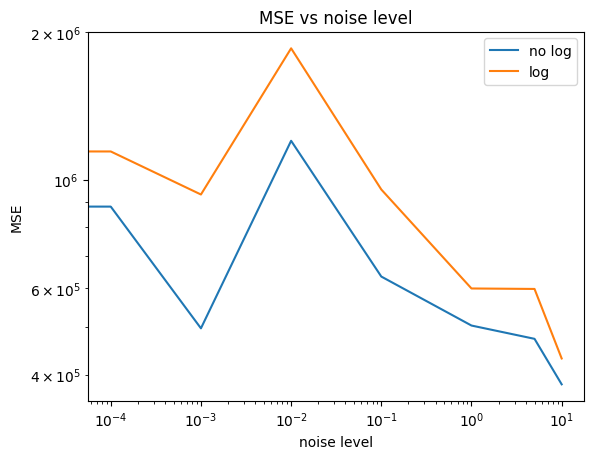

In [11]:
# plot the MSE
fig, ax = plt.subplots()
ax.plot(noise_levels, mse_nolog, label='no log')
ax.plot(noise_levels, mse_log, label='log')
ax.set_xlabel('noise level')
ax.set_ylabel('MSE')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('MSE vs noise level')
ax.legend()
plt.show()

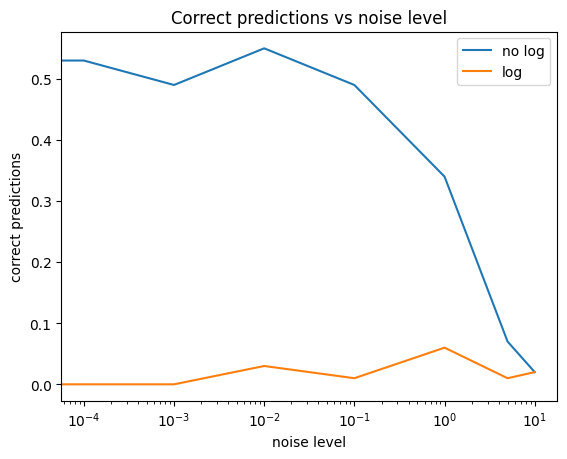

In [12]:
# plot correct predictions
fig, ax = plt.subplots()
ax.plot(noise_levels, correct_nolog, label='no log')
ax.plot(noise_levels, correct_log, label='log')
ax.set_xlabel('noise level')
ax.set_ylabel('correct predictions')
ax.set_xscale('log')
ax.set_title('Correct predictions vs noise level')
ax.legend()
plt.show()

Overall, the algorithm doesn't produce outstanding results, but is able to decipher the original fundamental frequency well enough until the signal is degraded with too much noise (notably around $\sigma = 1$).

## Recorded Voice

In [13]:
piranha_sample = wav.read('../data/piranha_plant_sample.wav')
piranha_fs, piranha_signal = piranha_sample

# segment to the first 0.2 seconds
piranha_signal = piranha_signal[int(0.2 * piranha_fs):int(0.8 * piranha_fs)]

# this pitch is b4, approximately 493.88 Hz
target_freq = 493.88

Estimated fundamental frequency: 3150.24 Hz


3150.2380952380954

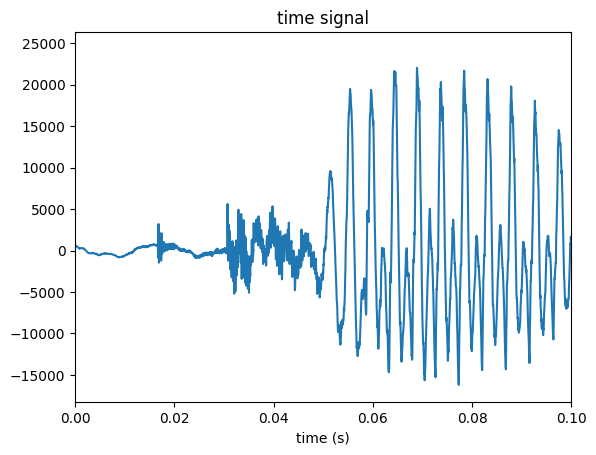

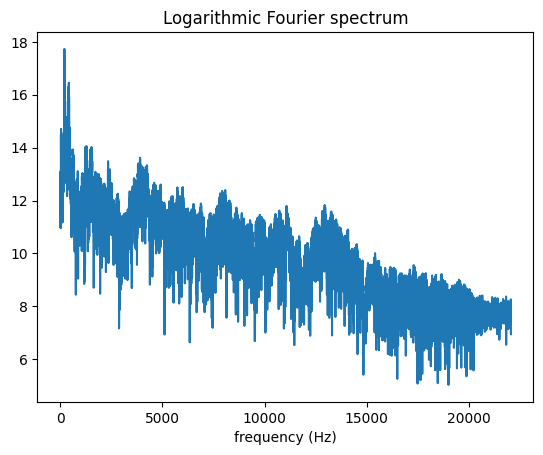

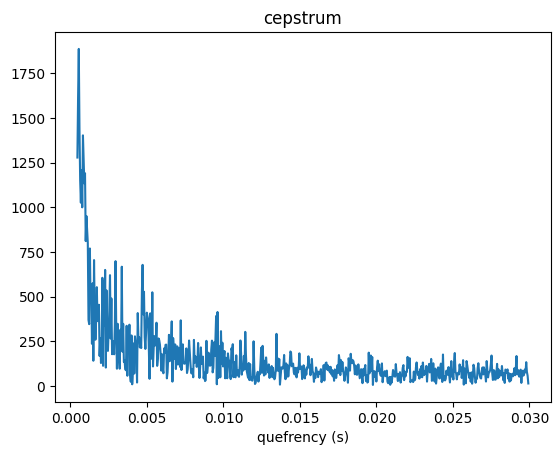

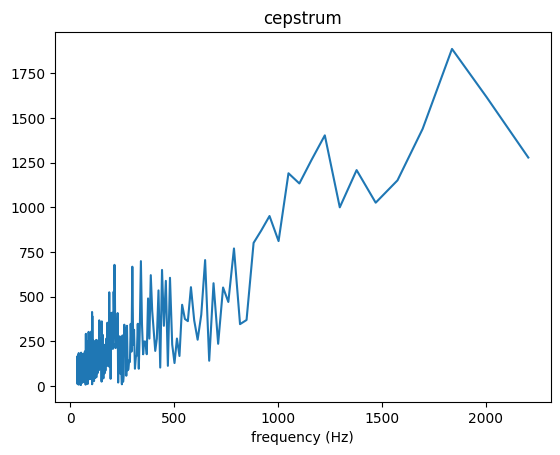

In [14]:
piranha_stepper = CepstrumStepper(piranha_signal, fmin=100, fmax=4000, fs=piranha_fs)
piranha_stepper.run_all(signal_plot_to=0.1, use_log=True, show_plots=True)

Estimated fundamental frequency: 3675.28 Hz


3675.277777777778

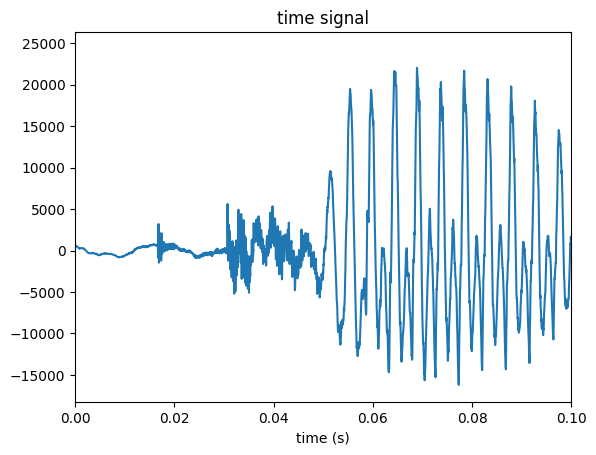

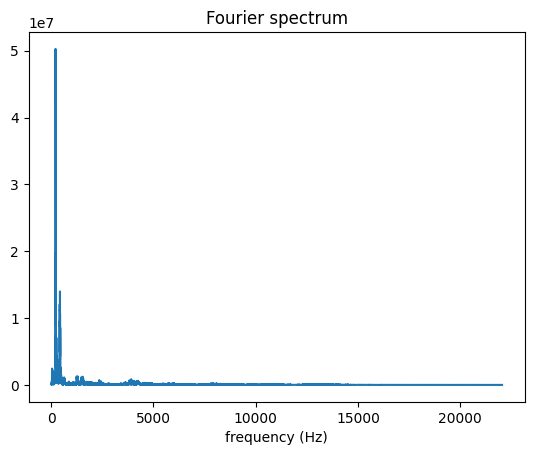

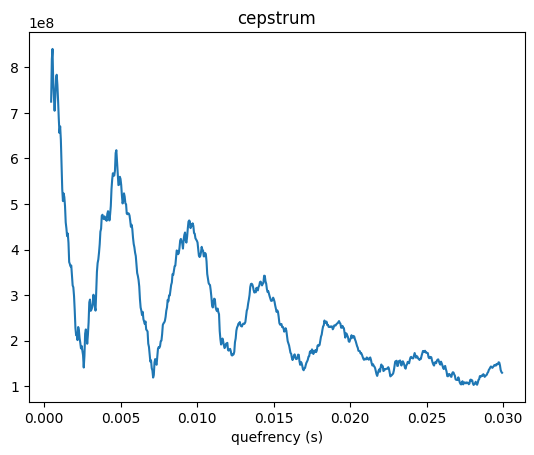

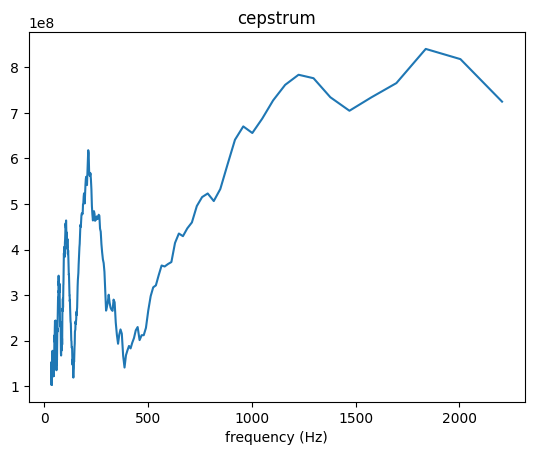

In [15]:
piranha_stepper.run_all(signal_plot_to=0.1, use_log=False, show_plots=True)

While the cepstrum method seemed to work somewhat with the synthetic signal, it doesn't do as well with a real audio sample - it doesn't seem to be able to handle the noise and irregularities that come with a recorded sample.

# References

- https://flothesof.github.io/cepstrum-pitch-tracking.html
- https://www.kuniga.me/blog/2021/12/11/pitch-via-cepstrum.html
- https://stackoverflow.com/questions/4583950/cepstral-analysis-for-pitch-detection
- https://www.reddit.com/r/DSP/comments/hcluof/eli5_what_is_cepstrum_why_do_we_need_that_what/
- https://ieeexplore.ieee.org/document/1328092